## Speedup & performance evaluation

* TODO: add visualization to evaluate the inference speedup & performance of tinyllama model after AWQ quantization

In [192]:
# load performance evaluation output from `lm-evaluation-harness` package
import json
 
# Opening JSON file
with open("evaluation/TinyLlama/results.json") as json_file:
    ori_perf = json.load(json_file)
with open("evaluation/TinyLlama_AWQ/results.json") as json_file:
    awq_perf = json.load(json_file)

In [351]:
## Calculate the accuracy degradation:
degrade_result = dict()

for task in ori_perf['results'].keys():
    degrade_result[task] = [100*(ori_perf['results'][task]['acc,none'] - awq_perf['results'][task]['acc,none'])]
df_degrade = pd.DataFrame(degrade_result)
df_degrade.columns = ['ARC Challenge', 'ARC Easy', 'BoolQ', 'Hellaswag', 'OpenBookQA', 'Winogrande']
df_degrade = df_degrade.melt(
    var_name = "Task",
    value_name="Accuracy Degradation (%)"
)

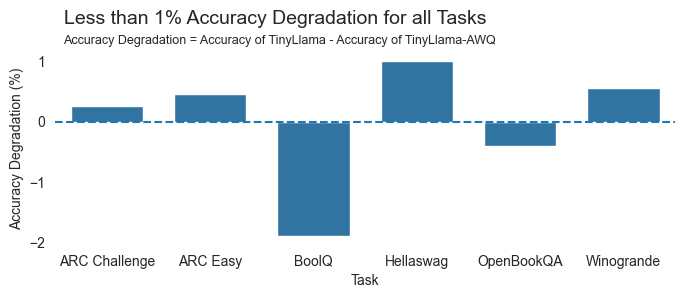

In [374]:
plt.figure(figsize=(8, 2.5))
ax = sns.barplot(x='Task', y='Accuracy Degradation (%)', data=df_degrade, width=0.7)
plt.axhline(y=0, linestyle='--', linewidth=1.5)  
plt.suptitle("Less than 1% Accuracy Degradation for all Tasks", x=0.4, size=14, y=1.05)
plt.title("Accuracy Degradation = Accuracy of TinyLlama - Accuracy of TinyLlama-AWQ", x=0.362, size=9)
sns.despine(bottom = True, left = True)

In [286]:
eval_result = dict()

for task in ori_perf['results'].keys():
    eval_result[task] = [100*ori_perf['results'][task]['acc,none'], 100*awq_perf['results'][task]['acc,none']]

In [352]:
# re-organize evaluation results for visualization
df_eval = pd.DataFrame(eval_result)
df_eval.columns = ['ARC Challenge', 'ARC Easy', 'BoolQ', 'Hellaswag', 'OpenBookQA', 'Winogrande']
df_eval['Model'] = ['TinyLlama', "TinyLlama-AWQ"]
df_eval = df_eval.melt(
    id_vars = "Model",
    var_name = "Task",
    value_name="Accuracy (%)"
)

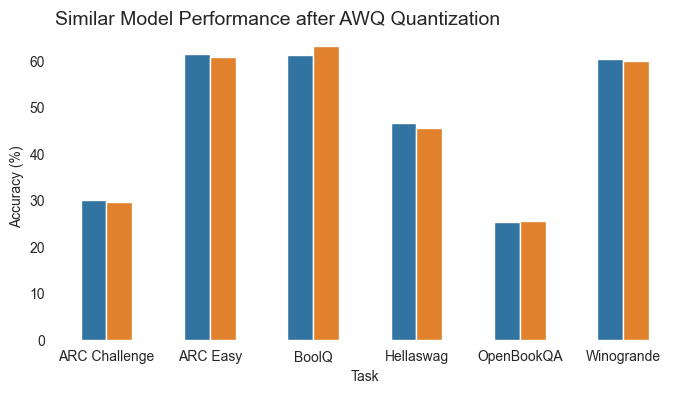

In [360]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 4))
ax = sns.barplot(x='Task', y='Accuracy (%)', data=df_eval, hue='Model', errorbar=None, legend=None, dodge=True, width=0.5)
sns.despine(bottom = True, left = True)
plt.title('Similar Model Performance after AWQ Quantization', loc='left', size=14,)
plt.show(ax)

### Speed

In [54]:
# load speed evaluation output data from speed_eval.py
import pandas as pd
import seaborn as sns
ori_speed = pd.read_csv("evaluation/TinyLlama/TinyLlama-1.1B-chat-v1.0_speed.csv")
awq_speed = pd.read_csv("evaluation/TinyLlama_AWQ/TinyLlama-1.1B-chat-v1.0-awq_speed.csv")

In [132]:
# combine token_per_sec of ori_speed and awq_speed into 1 dataframe
import numpy as np
speed_data = pd.DataFrame({
    "TinyLlama": ori_speed['token_per_sec'],
    "Tinyllama-AWQ": awq_speed['token_per_sec']
} 
)
speed_data = speed_data.melt(
    var_name = "Model",
    value_name="token_per_sec"
)
speed_data.head()

,Model,token_per_sec
0,TinyLlama,77.118083
1,TinyLlama,87.909427
2,TinyLlama,89.667286
3,TinyLlama,88.407320
4,TinyLlama,87.945744


In [150]:
# calculate speed up:
np.mean(awq_speed['token_per_sec']) / np.mean(ori_speed['token_per_sec'])

1.6214152737890628

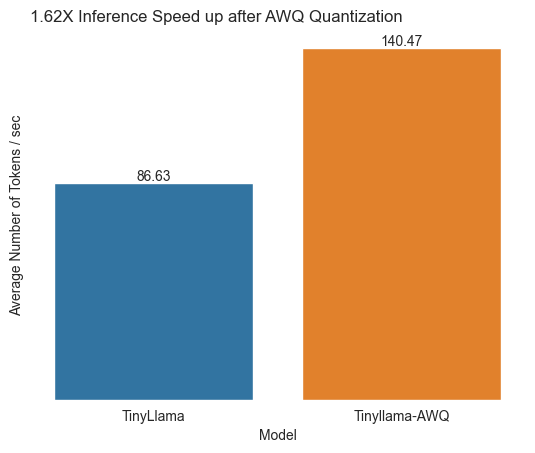

In [391]:
from matplotlib import pyplot as plt

ax = sns.barplot(x='Model', y='token_per_sec', data=speed_data, hue='Model', errorbar=None)
# errorbar="sd", capsize=.3, zorder=5
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()-3), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
# plt.gca().axes.yaxis.set_visible(False)
ax.yaxis.set_ticks([])
ax.yaxis.set_ticklabels([])
plt.title('1.62X Inference Speed up after AWQ Quantization', loc='left')
plt.xlabel('Model')
plt.ylabel('Average Number of Tokens / sec')
sns.despine(bottom = True, left = True)

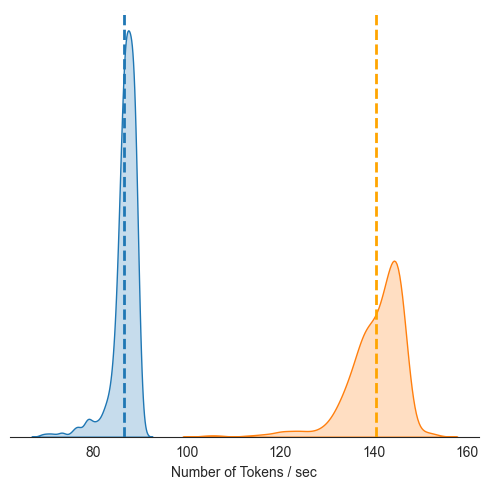

In [403]:
ax = sns.displot(x='token_per_sec', hue = 'Model', fill = 'Model', data=speed_data, kind="kde", legend=None)
plt.xlabel('Number of Tokens / sec')
sns.despine(left = True)
plt.gca().axes.yaxis.set_visible(False)
plt.axvline(x=86.63, linestyle='--', linewidth=2)  
plt.axvline(x=140.47, linestyle='--', linewidth=2, color='orange')
plt.tight_layout()

## Memory footprint

In [178]:
from transformers import AutoModelForCausalLM
# load models from Local:
tinyllama = AutoModelForCausalLM.from_pretrained("../models/TinyLlama-1.1B-chat-v1.0", device_map="cuda:0")
tinyllama_awq = AutoModelForCausalLM.from_pretrained("../models/TinyLlama-1.1B-chat-v1.0-awq", device_map="cuda:0")

In [182]:
tinyllama_size = tinyllama.get_memory_footprint()/1e+6
tinyllama_awq_size = tinyllama_awq.get_memory_footprint()/1e+6
print(f"""
Footprint of the model in MBs: 
Tinyllama: {tinyllama_size}
Tinyllama: {tinyllama_awq_size}

Model size compression: {tinyllama_awq_size/tinyllama_size}
"""
      )


Footprint of the model in MBs: 
Tinyllama: 4423.265024
Tinyllama: 777.231104

Model size compression: 0.17571434218453014



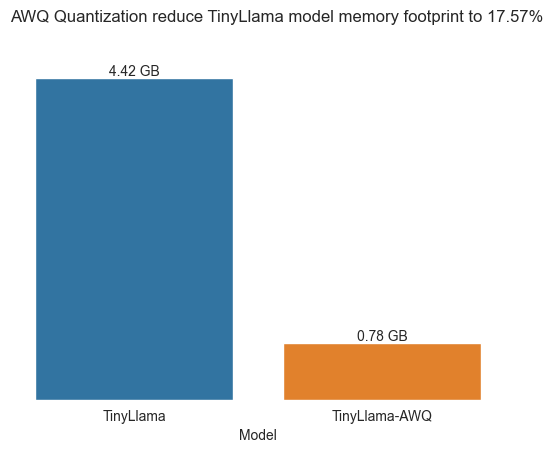

In [416]:
df_size = pd.DataFrame({
    "Model": ["TinyLlama", "TinyLlama-AWQ"],
    "Memory Footprint (GB)": [tinyllama_size/1e3, tinyllama_awq_size/1e3]
})
ax = sns.barplot(x='Model', y='Memory Footprint (GB)', data=df_size, hue='Model', errorbar=None)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f} GB', 
                (p.get_x() + p.get_width() / 2., p.get_height()-0.1), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title('AWQ Quantization reduce TinyLlama model memory footprint to 17.57%', loc='left')
sns.despine(bottom = True, left = True)
plt.gca().axes.yaxis.set_visible(False)
plt.margins(y=0.15)